#Series de Tiempo --- Estimación de inflación


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [60]:
ruta_de_archivo = '/content/drive/MyDrive/IPC de 2017-2024 para estimación.xlsx'
ipc = pd.read_excel(ruta_de_archivo)
ipc.tail()

,Fecha,IPC,IPCS,Unnamed: 3
92,2024-09-01,0.035,7122.367033,NaN
93,2024-10-01,0.027,7314.670942,NaN
94,2024-11-01,0.024,7490.223045,NaN
95,2024-12-01,0.027,7692.459067,NaN
96,2025-01-01,0.022,7861.693167,NaN


In [34]:
ipc= ipc.iloc[60:]


In [61]:
ipc.head()

,Fecha,IPC,IPCS,Unnamed: 3
0,2017-01-01,0.015859,101.5859,NaN
1,2017-02-01,0.020672,103.6859,NaN
2,2017-03-01,0.023742,106.1476,NaN
3,2017-04-01,0.026558,108.9667,NaN
4,2017-05-01,0.014348,110.5301,NaN


In [62]:
ipc = ipc.reset_index(drop=True)

ipc.head()

,Fecha,IPC,IPCS,Unnamed: 3
0,2017-01-01,0.015859,101.5859,NaN
1,2017-02-01,0.020672,103.6859,NaN
2,2017-03-01,0.023742,106.1476,NaN
3,2017-04-01,0.026558,108.9667,NaN
4,2017-05-01,0.014348,110.5301,NaN


In [37]:
ipc.tail()

,Fecha,IPC,IPCS,Unnamed: 3
32,2024-09-01,0.035,7122.367033,NaN
33,2024-10-01,0.027,7314.670942,NaN
34,2024-11-01,0.024,7490.223045,NaN
35,2024-12-01,0.027,7692.459067,NaN
36,2025-01-01,0.022,7861.693167,NaN


In [38]:
ipc = ipc.iloc[:-1]

In [39]:
ipc_promedio = np.mean(ipc['IPC'])
ipc_promedio

0.07530975547165439

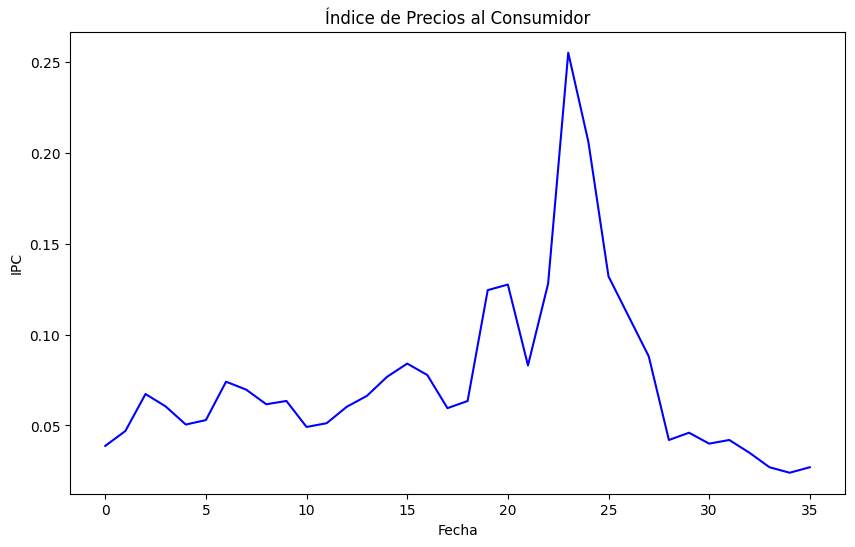

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(ipc['IPC'], color='blue')
plt.xlabel('Fecha')
plt.ylabel('IPC')
plt.title('Índice de Precios al Consumidor')

plt.show()

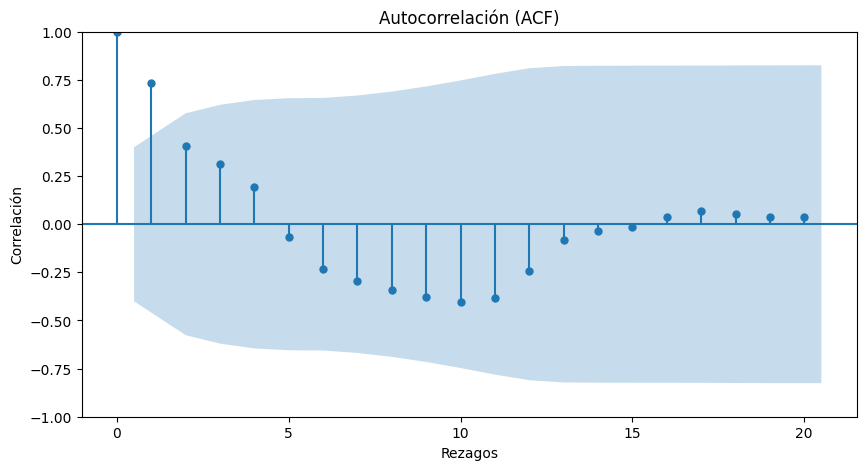

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Generar el gráfico de la ACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ipc['IPC'], ax=ax, lags=20)
plt.xlabel('Rezagos')
plt.ylabel('Correlación')
plt.title('Autocorrelación (ACF)')
plt.show()

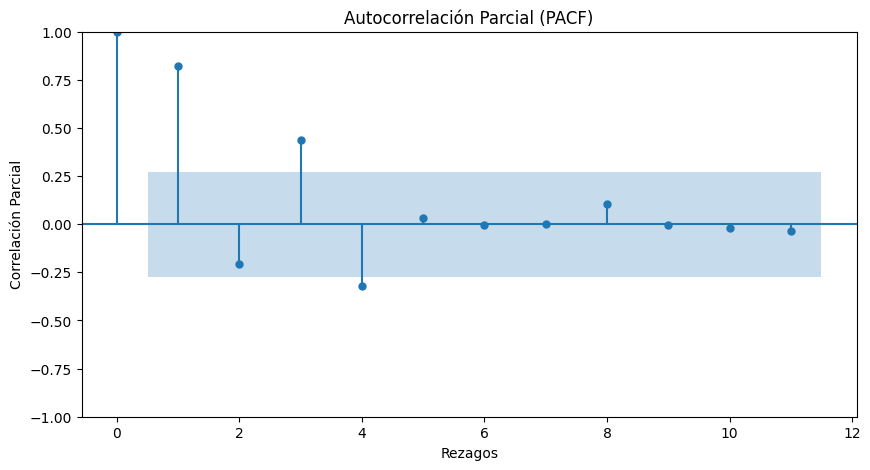

In [ ]:
# Generar el gráfico de la PACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(ipc['IPC'], ax=ax, lags=11)
plt.xlabel('Rezagos')
plt.ylabel('Correlación Parcial')
plt.title('Autocorrelación Parcial (PACF)')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Aplicar la prueba de Dickey-Fuller aumentada (ADF) a la serie de tiempo de inflación
result_inflation = adfuller(ipc['IPC'])
print('Prueba de Dickey-Fuller aumentada (ADF) - Inflación:')
print(f'Estadístico de prueba: {result_inflation[0]}')
print(f'Valor p: {result_inflation[1]*100}')
print(f'Valores críticos: {result_inflation[4]}')
print(f'Estacionaria: {result_inflation[1] < 0.10}')

Prueba de Dickey-Fuller aumentada (ADF) - Inflación:
Estadístico de prueba: -2.1846737884201883
Valor p: 21.185493581874304
Valores críticos: {'1%': -3.610399601308181, '5%': -2.939108945868946, '10%': -2.6080629651545038}
Estacionaria: False


Encuentro que mi variable no es estacionaria.

Quiero chequear otro test. La biblioteca arch en Python proporciona la funcionalidad para realizar pruebas de raíz unitaria, incluyendo el test de Phillips-Perron.

In [ ]:
pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 5.3 MB/s eta 0:00:00


In [ ]:
import arch.unitroot as at
pp = at.PhillipsPerron(ipc['IPC'], trend='ct', test_type='rho')
stat = pp.stat
print(f"test stat. : {pp.stat}")
print(f"p-value: {pp.pvalue}")
print(f"critical values: {pp.critical_values}")
critical_values = pp.critical_values


# print pair equation
import sys
green_bg = '\u001b[42;1m'
red_bg = '\u001b[41;1m'
reset_bg = '\u001b[0m'
print(f"90% CONFIDENCE: {green_bg + 'PASSED' if critical_values['10%']>stat else red_bg + ' FAILED'}{reset_bg}")
print(f"95% CONFIDENCE: {green_bg + 'PASSED (H0 rejected, the time series is stationary)' if critical_values['5%']>stat else red_bg + ' FAILED (residuals seem to contain a unit root, the time series is non-stationary)'}{reset_bg}")
print(f"99% CONFIDENCE: {green_bg + 'PASSED (H0 rejected, the time series is stationary)' if critical_values['1%']>stat else red_bg + ' FAILED (residuals seem to contain a unit root, the time series is non-stationary)'}{reset_bg}")


test stat. : -8.64321353905596
p-value: 0.5310041510538929
critical values: {'1%': -24.446283574532988, '5%': -18.88228477526725, '10%': -16.189440890697547}
90% CONFIDENCE:  FAILED
95% CONFIDENCE:  FAILED (residuals seem to contain a unit root, the time series is non-stationary)
99% CONFIDENCE:  FAILED (residuals seem to contain a unit root, the time series is non-stationary)


La serie es estacionaria bajo el test de Phillips Perron.

Procederemos a elegir nuestro mejor modelo, con los criterios de información Akaike y Bayesiano.

In [ ]:
import warnings

# Desactivar las advertencias de statsmodels
warnings.filterwarnings("ignore", category=Warning)


from statsmodels.tsa.arima.model import ARIMA
#Modelo ARIMA (p, d, q)

# Estimación de órdenes del modelo ARIMA utilizando criterios BIC y AIC
order_bic = None  # Variable para almacenar el orden óptimo según BIC
order_aic = None  # Variable para almacenar el orden óptimo según AIC
best_bic = np.inf  # Mejor valor de BIC inicializado en infinito
best_aic = np.inf  # Mejor valor de AIC inicializado en infinito

# Iteración sobre diferentes órdenes (p, d, q)
for p in range(5):
    for d in range(6):
        for q in range(7):
            try:
                # Ajuste del modelo ARIMA con el orden actual
                model = ARIMA(ipc['IPC'], order=(p, d, q))
                model_fit = model.fit()
                bic = model_fit.bic  # Cálculo del valor de BIC
                aic = model_fit.aic  # Cálculo del valor de AIC

                # Actualización del orden óptimo según BIC
                if bic < best_bic:
                    best_bic = bic
                    order_bic = (p, d, q)

                # Actualización del orden óptimo según AIC
                if aic < best_aic:
                    best_aic = aic
                    order_aic = (p, d, q)

            except:
                continue

print("Orden óptimo según BIC:", order_bic)
print("Orden óptimo según AIC:", order_aic)

# Reactivar las advertencias de statsmodels
warnings.filterwarnings("default", category=Warning)



Orden óptimo según BIC: (0, 0, 2)
Orden óptimo según AIC: (0, 0, 5)


In [ ]:
import warnings

from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore", category=Warning)

model = ARIMA(ipc['IPC'], order=(0,1,2))
model_fit = model.fit()

forecast = model_fit.get_forecast(steps=2)

pred_values = forecast.predicted_mean * 100
pred_interval = forecast.conf_int(alpha=0.15) * 100


warnings.filterwarnings("default", category=Warning)

In [ ]:
pred_values

,predicted_mean
36,3.065077
37,2.927234


In [ ]:
pred_interval

,lower IPC,upper IPC
24,-1.959812,8.044076
25,-4.905291,10.726800


In [ ]:
pred_febrero = pred_values[43]
pred_marzo = pred_values[44]

# Obtengo los límites superior e inferior del intervalo de predicción
lower_bound_febrero = pred_interval.iloc[0, 0]
upper_bound_febrero = pred_interval.iloc[0, 1]
lower_bound_marzo = pred_interval.iloc[1, 0]
upper_bound_marzo = pred_interval.iloc[1, 1]

y_actual = ipc['IPC']
y_pred = model_fit.fittedvalues
ssr = np.sum((y_actual - y_pred) ** 2)
sst = np.sum((y_actual - np.mean(y_actual)) ** 2)
r2 = 1 - (ssr / sst)

model_stats = model_fit.summary()

print('La predicción de la inflación para febrero de 2025 es:', round(pred_febrero, 3))
print('Intervalo de predicción para febrero de 2025:', f"({round(lower_bound_febrero, 3)}, {round(upper_bound_febrero, 3)})")
print('La predicción de la inflación para marzo de 2025 es:', round(pred_marzo, 3))
print('Intervalo de predicción para marzo de 2025:', f"({round(lower_bound_marzo, 3)}, {round(upper_bound_marzo, 3)})")
print('El R cuadrado ajustado del modelo es:', round(r2, 2))
print('Estadísticas y detalles del modelo:')
print(model_stats)



La predicción de la inflación para Mayo de 2024 es: 3.192
Intervalo de predicción para Mayo de 2024: (-1.137, 7.521)
La predicción de la inflación para Junio de 2024 es: 4.183
Intervalo de predicción para Junio de 2024: (-2.596, 10.961)
El R cuadrado ajustado del modelo es: 0.66
Estadísticas y detalles del modelo:
                               SARIMAX Results                                
Dep. Variable:                    IPC   No. Observations:                   43
Model:                 ARIMA(0, 1, 2)   Log Likelihood                  92.977
Date:                Thu, 12 Sep 2024   AIC                           -179.953
Time:                        14:37:08   BIC                           -174.740
Sample:                             0   HQIC                          -178.042
                                 - 43                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


XGBoost

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


In [78]:
ruta_de_archivo = '/content/drive/MyDrive/serie infla 2003-2023 para estimacion.xlsx'
ipc = pd.read_excel(ruta_de_archivo)
ipc.tail()

,Fecha,CPI
260,2024-09-01,0.035
261,2024-10-01,0.027
262,2024-11-01,0.024
263,2024-12-01,0.027
264,2025-01-01,0.022


In [79]:
ipc.rename(columns={'CPI': 'IPC'}, inplace=True)


In [80]:
print("Primeras filas de ipc:")
print(ipc.head())

print("\nInformación de ipc:")
print(ipc.info())

print("\nValores nulos en IPC:", ipc['IPC'].isna().sum())
print("Tamaño original de ipc:", ipc.shape[0])


Primeras filas de ipc:
       Fecha       IPC
0 2003-01-01  0.131000
1 2003-02-01  0.013193
2 2003-03-01  0.005660
3 2003-04-01  0.005838
4 2003-05-01  0.000552

Información de ipc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   265 non-null    datetime64[ns]
 1   IPC     265 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.3 KB
None

Valores nulos en IPC: 0
Tamaño original de ipc: 265


In [81]:
ipc['Fecha'] = pd.to_datetime(ipc['Fecha'])
ipc.set_index('Fecha', inplace=True)
ipc = ipc.sort_index()


In [122]:
def create_lag_features(data, lags=12):
    df = data.copy()

    # Genero columnas con rezagos de IPC
    for lag in range(1, lags+1):
        df[f'IPC_lag_{lag}'] = df['IPC'].shift(lag)

    # Variaciones absolutas y relativas
    df['IPC_diff'] = df['IPC'].diff()
    df['IPC_pct_change'] = df['IPC'].pct_change()

    # Volatilidad en distintas ventanas de tiempo
    df['IPC_volatilidad_3m'] = df['IPC'].rolling(window=3).std()
    df['IPC_volatilidad_6m'] = df['IPC'].rolling(window=6).std()
    df['IPC_volatilidad_12m'] = df['IPC'].rolling(window=12).std()

    return df

lags = min(12, ipc.shape[0] - 1)
ipc_lagged = create_lag_features(ipc, lags)

# Verifico cantidad de datos disponibles después de generar las variables
print("Tamaño antes de eliminar nulos:", ipc_lagged.shape)

if ipc_lagged.shape[0] > lags:
    ipc_lagged.dropna(inplace=True)
    print("Tamaño después de eliminar nulos:", ipc_lagged.shape)
else:
    print("Advertencia: Insuficientes datos tras aplicar rezagos.")

# Defino variables predictoras y objetivo
if 'IPC' in ipc_lagged.columns:
    X = ipc_lagged.drop(columns=['IPC'])
    y = ipc_lagged['IPC']
    print(f"Dimensiones de X: {X.shape}, Dimensiones de y: {y.shape}")
else:
    print("Error: No se encuentra la columna IPC en el dataset.")


Después de agregar lags - ipc_lagged shape: (265, 16)
Después de dropna - ipc_lagged shape: (253, 16)
X shape: (253, 15), y shape: (253,)


In [123]:
# División del dataset en entrenamiento y prueba
train_size = int(len(X) * 0.8)  # 80% entrenamiento, 20% prueba
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [124]:

# Modelo base de XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1]
}

# Validación cruzada respetando la estructura temporal
tscv = TimeSeriesSplit(n_splits=4)

# Búsqueda de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(
    xgb_model, param_grid,
    cv=tscv, scoring='neg_mean_squared_error',
    verbose=1, n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)


Fitting 4 folds for each of 432 candidates, totalling 1728 fits
Mejores hiperparámetros: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}


MAE: 0.0243
RMSE: 0.0462


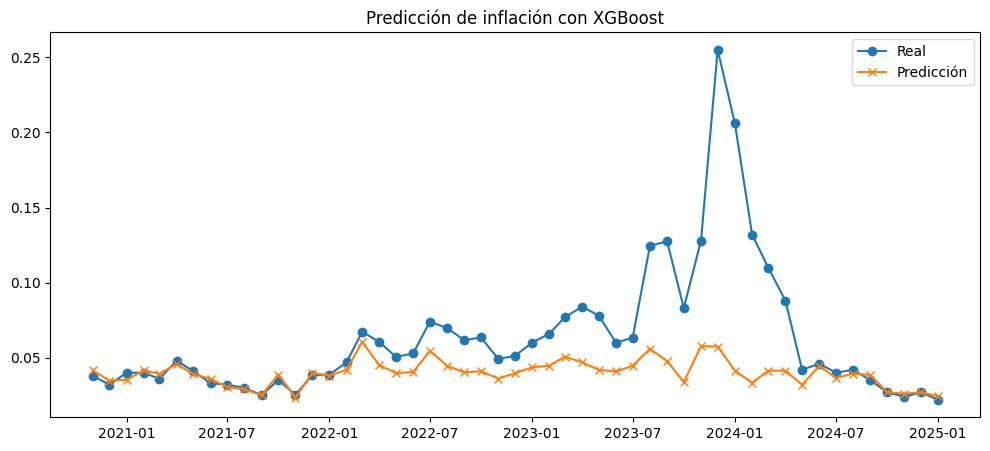

In [126]:
best_xgb_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_xgb_model.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred = np.expm1(best_xgb_model.predict(X_test))  # Invertimos la transformación logarítmica

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Real", marker="o")
plt.plot(y_test.index, y_pred, label="Predicción", marker="x")
plt.legend()
plt.title("Predicción de inflación con XGBoost")
plt.show()


In [129]:
last_values = ipc_lagged.iloc[-1:].drop(columns=['IPC'])  # Tomamos la última fila con los lags

# Predicción de los próximos valores
num_forecasts = 2
future_predictions = []

for _ in range(num_forecasts):
    pred = best_xgb_model.predict(last_values)[0]  # Predecir un valor
    future_predictions.append(pred)

    # Actualizo los lags con la nueva predicción
    new_row = last_values.iloc[-1, 1:].tolist() + [pred]  # Desplazar lags
    last_values = pd.DataFrame([new_row], columns=X.columns)

print("Predicciones futuras:", future_predictions)


Predicciones futuras: [0.024203278, 0.02407103]


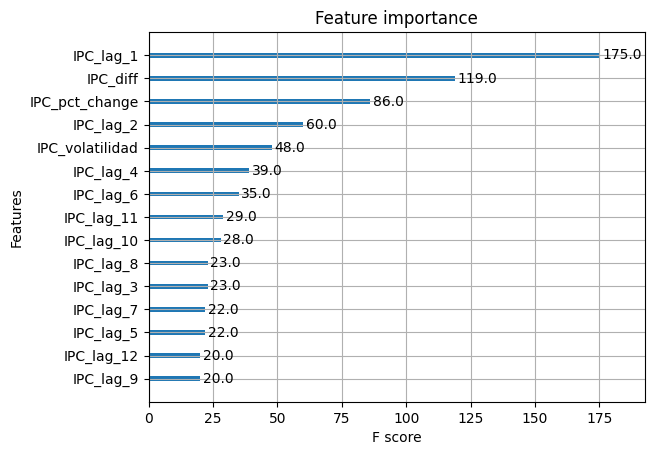

In [128]:
xgb.plot_importance(best_xgb_model)
plt.show()
